# Installations and imports

In [1]:
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import requests
import json
import matplotlib.pyplot as plt
import re
import pprint
import warnings
warnings.filterwarnings("ignore")
import yfinance as yf
import seaborn as sns
from datetime import date,datetime
from datetime import date
import locale
locale.setlocale(locale.LC_ALL, '')
import helper_functions as hp

# Important economic indicators

- https://www.finra.org/investors/insights/key-economic-indicators-every-investor-should-know

- https://www.investopedia.com/articles/personal-finance/020215/top-ten-us-economic-indicators.asp

- https://www.discoveroptions.com/mixed/content/education/articles/bigthreeeconomicindicators.html

# Retrievng major index and asset values - *Rapid API*
- S&P 500
- Dow 30
- Nasdaq
- Russell 2000
- Crude Oil
- FTSE 100
- Gold
- Bitcoin

In [2]:
indexes = ['S&P 500','Dow 30','Nasdaq','Russell 2000','Crude Oil','FTSE 100','Gold','Bitcoin']
tickers = ["^GSPC","^DJI","NQ=F","RTY=F","CL=F","^FTSE","GC=F","BTC-USD"]

df_index = hp.retrieve_indexes_and_assets(indexes,tickers)

print (df_index)

   Current Price  Change Percent         Index
0       3924.260       -1.793969       S&P 500
1      31318.440       -1.692485        Dow 30
2      12160.500        0.411167        Nasdaq
3       1821.400        0.620402  Russell 2000
4         88.580        1.964326     Crude Oil
5       7287.430        0.085627      FTSE 100
6       1729.000        0.277617          Gold
7      19769.748       -0.181808       Bitcoin


# Scraping Covid cases data - *Worldometer*
https://www.worldometers.info/coronavirus/country/us/

In [3]:
url = "https://www.worldometers.info/coronavirus/country/us/"
cases = hp.extract_covid_cases(url)

print ("Cases",':',cases['Cases'])
print ("Deaths",':',cases['Deaths'])
print ("Recoveries",':',cases['Recoveries'])

Cases : 96,643,172 
Deaths : 1,072,978
Recoveries : 92,602,975


# Scraping Covid vaccinations data - *New York Times*

https://www.nytimes.com/interactive/2020/us/covid-19-vaccine-doses.html

In [4]:
url = "https://www.nytimes.com/interactive/2020/us/covid-19-vaccine-doses.html"
vac_labels, vac_values = hp.extract_covid_vaccinations(url)

print ("At least one shot: ",vac_values[0])
print ("Two shots: ",vac_values[1])
print ("Booster shot: ",vac_values[2])
print("Total shots: ",vac_values[3])
print("Two shots 65+: ",vac_values[4])

At least one shot:  79%
Two shots:  67%
Booster shot:  33%
Total shots:  610,012,616
Two shots 65+:  92%


Note: The html text for the *class* attribute seemed to have changed on the NYT website. So the text used for parsing needed to be changed. The previous code containing the older parsing method is also shown above but commented out. 

# Extracting VIX Volatility Index data - *Yahoo Finance API*

### VIX Volatility Index

In [5]:
data = hp.extract_stock_info("^VIX")
vix = data['result']['regularMarketPrice']

# get stock info
print ("VIX:",vix)

VIX: 25.99


# Scraping Treasury Yield Data - YCharts

- https://home.treasury.gov/resource-center/data-chart-center/interest-rates/TextView?type=daily_treasury_yield_curve&field_tdr_date_value_month=202203
- https://www.bloomberg.com/markets/rates-bonds/government-bonds/us

In [6]:
#Retrieving treasury rates 
df_rates = hp.extract_treasury_rates('https://home.treasury.gov/resource-center/data-chart-center/interest-rates/TextView?type=daily_treasury_yield_curve&field_tdr_date_value_month=202203')

df_rates.head()

,1mo,3mo,6mo,1yr,3yr,5yr,10yr,20yr,30yr
Date,,,,,,,,,
2022-03-01,0.11,0.32,0.60,0.91,1.47,1.56,1.72,2.19,2.11
2022-03-02,0.13,0.34,0.68,1.06,1.67,1.74,1.86,2.32,2.24
2022-03-03,0.19,0.38,0.69,1.08,1.69,1.74,1.86,2.32,2.24
2022-03-04,0.15,0.34,0.69,1.05,1.62,1.65,1.74,2.23,2.16
2022-03-07,0.17,0.38,0.75,1.07,1.68,1.71,1.78,2.29,2.19


In [7]:
#Creating data points for yield curve
yield_curve = df_rates.iloc[-1,:-1]
yield_curve

1mo     0.17
3mo     0.52
6mo     1.06
1yr     1.63
3yr     2.45
5yr     2.42
10yr    2.32
20yr    2.59
Name: 2022-03-31 00:00:00, dtype: float64

# Scraping unemployment rates - U.S. Bureau of Labor Statistics
https://data.bls.gov/timeseries/LNS14000000

In [8]:
#Calling function to extract unemployment values
url = 'https://data.bls.gov/timeseries/LNS14000000'
df_unemp_rate = hp.extract_unemp_rate(url)

df_unemp_rate.head()

,date,unemployment_rate_percent
date,,
2012-01-01,2012-01-01,8.3
2012-02-01,2012-02-01,8.3
2012-03-01,2012-03-01,8.2
2012-04-01,2012-04-01,8.2
2012-05-01,2012-05-01,8.2


# Scraping GDP data - U.S. Inflation Calculator
https://www.usinflationcalculator.com/inflation/historical-inflation-rates/

In [9]:
#Calling function to extract inflation data
url = 'https://www.usinflationcalculator.com/inflation/historical-inflation-rates/'
df_inflation = hp.extract_inflation_rate(url)

df_inflation.head()

,date,inflation_rate
date,,
1914-01-01,1914-01-01,2.0
1914-02-01,1914-02-01,1.0
1914-03-01,1914-03-01,1.0
1914-04-01,1914-04-01,0.0
1914-05-01,1914-05-01,2.1


# Scraping Gross Domestic Product (GDP) - Multpl
https://www.multpl.com/us-gdp-inflation-adjusted/table/by-year

In [10]:
#Calling function to extract GDP data
url = 'https://www.multpl.com/us-gdp-inflation-adjusted/table/by-year'
df_gdp = hp.extract_gdp(url)

df_gdp.head()

,date,gdp
date,,
2022-06-30,2022-06-30,19.70
2021-12-31,2021-12-31,19.81
2020-12-31,2020-12-31,18.77
2019-12-31,2019-12-31,19.20
2018-12-31,2018-12-31,18.72


# Calculating Buffet Indicator

https://www.gurufocus.com/stock-market-valuations.php

https://www.gurufocus.com/shiller-PE.php

https://www.multpl.com/shiller-pe

##### $Buffet$ $indicator$ = $U.S.$ $Equity$ $Market$ $Value$ $/$ $U.S.$ $GDP$

1. Scraping Market Value of U.S. Stock Market - Siblis Research

https://siblisresearch.com/data/us-stock-market-value/#:~:text=The%20total%20market%20capitalization%20of,about%20OTC%20markets%20from%20here.

2. U.S. GDP - Extracted in the GDP section of this notebook

In [11]:
#Calling function to calculate Buffet Indicator after extracting US total market value
url = 'https://siblisresearch.com/data/us-stock-market-value/#:~:text=The%20total%20market%20capitalization%20of,about%20OTC%20markets%20from%20here.'
buffet_ind = hp.calculate_buffet_indicator(url,df_gdp)

print ("Buffet indicator: ",buffet_ind,"%")

U.S. Equity Maret Cap: $ 53366436400000.0
U.S. GDP: $ 19700000000000.0
Buffet indicator:  270.9 %


# Extracting Shiller PE Ratio

https://www.gurufocus.com/shiller-PE.php

https://www.multpl.com/shiller-pe

In [12]:
#Calling function to extract Shiller PE value
url = 'https://www.multpl.com/shiller-pe'
shiller_pe = hp.extract_shiller_pe(url)

print ("Shiller PE Ratio: ",shiller_pe)

Shiller PE Ratio:  29.36


# FINRA Margin Debt

https://www.finra.org/investors/learn-to-invest/advanced-investing/margin-statistics

https://www.advisorperspectives.com/dshort/updates/2021/08/12/margin-debt-and-the-market-down-4-3-in-july-first-decline-in-15-months

In [13]:
#Calculating 
url = 'https://www.finra.org/investors/learn-to-invest/advanced-investing/margin-statistics'
df_debt, latest_data = hp.extract_debt_margin(url)

print ("Latest Margin Debt Data: ",list(latest_data['date'])[-1], ", $" + str(list(latest_data['debt'])[-1]*1000000))

df_debt.head()

Latest Margin Debt Data:  Dec-21 , $910021000000


,date,debt
0,Jan-22,829637
1,Feb-22,835255
2,Mar-22,799659
3,Apr-22,772940
4,May-22,752944


# 15-Year and 30-Year Fixed-Rate Mortgages

- https://www.freddiemac.com/pmms/pmms15
- https://www.freddiemac.com/pmms/pmms30

### 15-Year Mortgages

In [14]:
url = 'https://www.freddiemac.com/pmms/pmms15'
df_mortgage_15yr = hp.extract_mortgage_rates(url)

df_mortgage_15yr.head()

,rate,month,year,date
date,,,,
2008-01-01,5.29,January,2008,2008-01-01
2008-02-01,5.44,February,2008,2008-02-01
2008-03-01,5.42,March,2008,2008-03-01
2008-04-01,5.47,April,2008,2008-04-01
2008-05-01,5.60,May,2008,2008-05-01


### 30-Year Mortgages

In [15]:
url = 'https://www.freddiemac.com/pmms/pmms30'
df_mortgage_30yr = hp.extract_mortgage_rates(url)

df_mortgage_30yr.head()

,rate,month,year,date
date,,,,
2008-01-01,5.76,January,2008,2008-01-01
2008-02-01,5.92,February,2008,2008-02-01
2008-03-01,5.97,March,2008,2008-03-01
2008-04-01,5.92,April,2008,2008-04-01
2008-05-01,6.04,May,2008,2008-05-01


# Dashboard

Creating a grid to display all the information

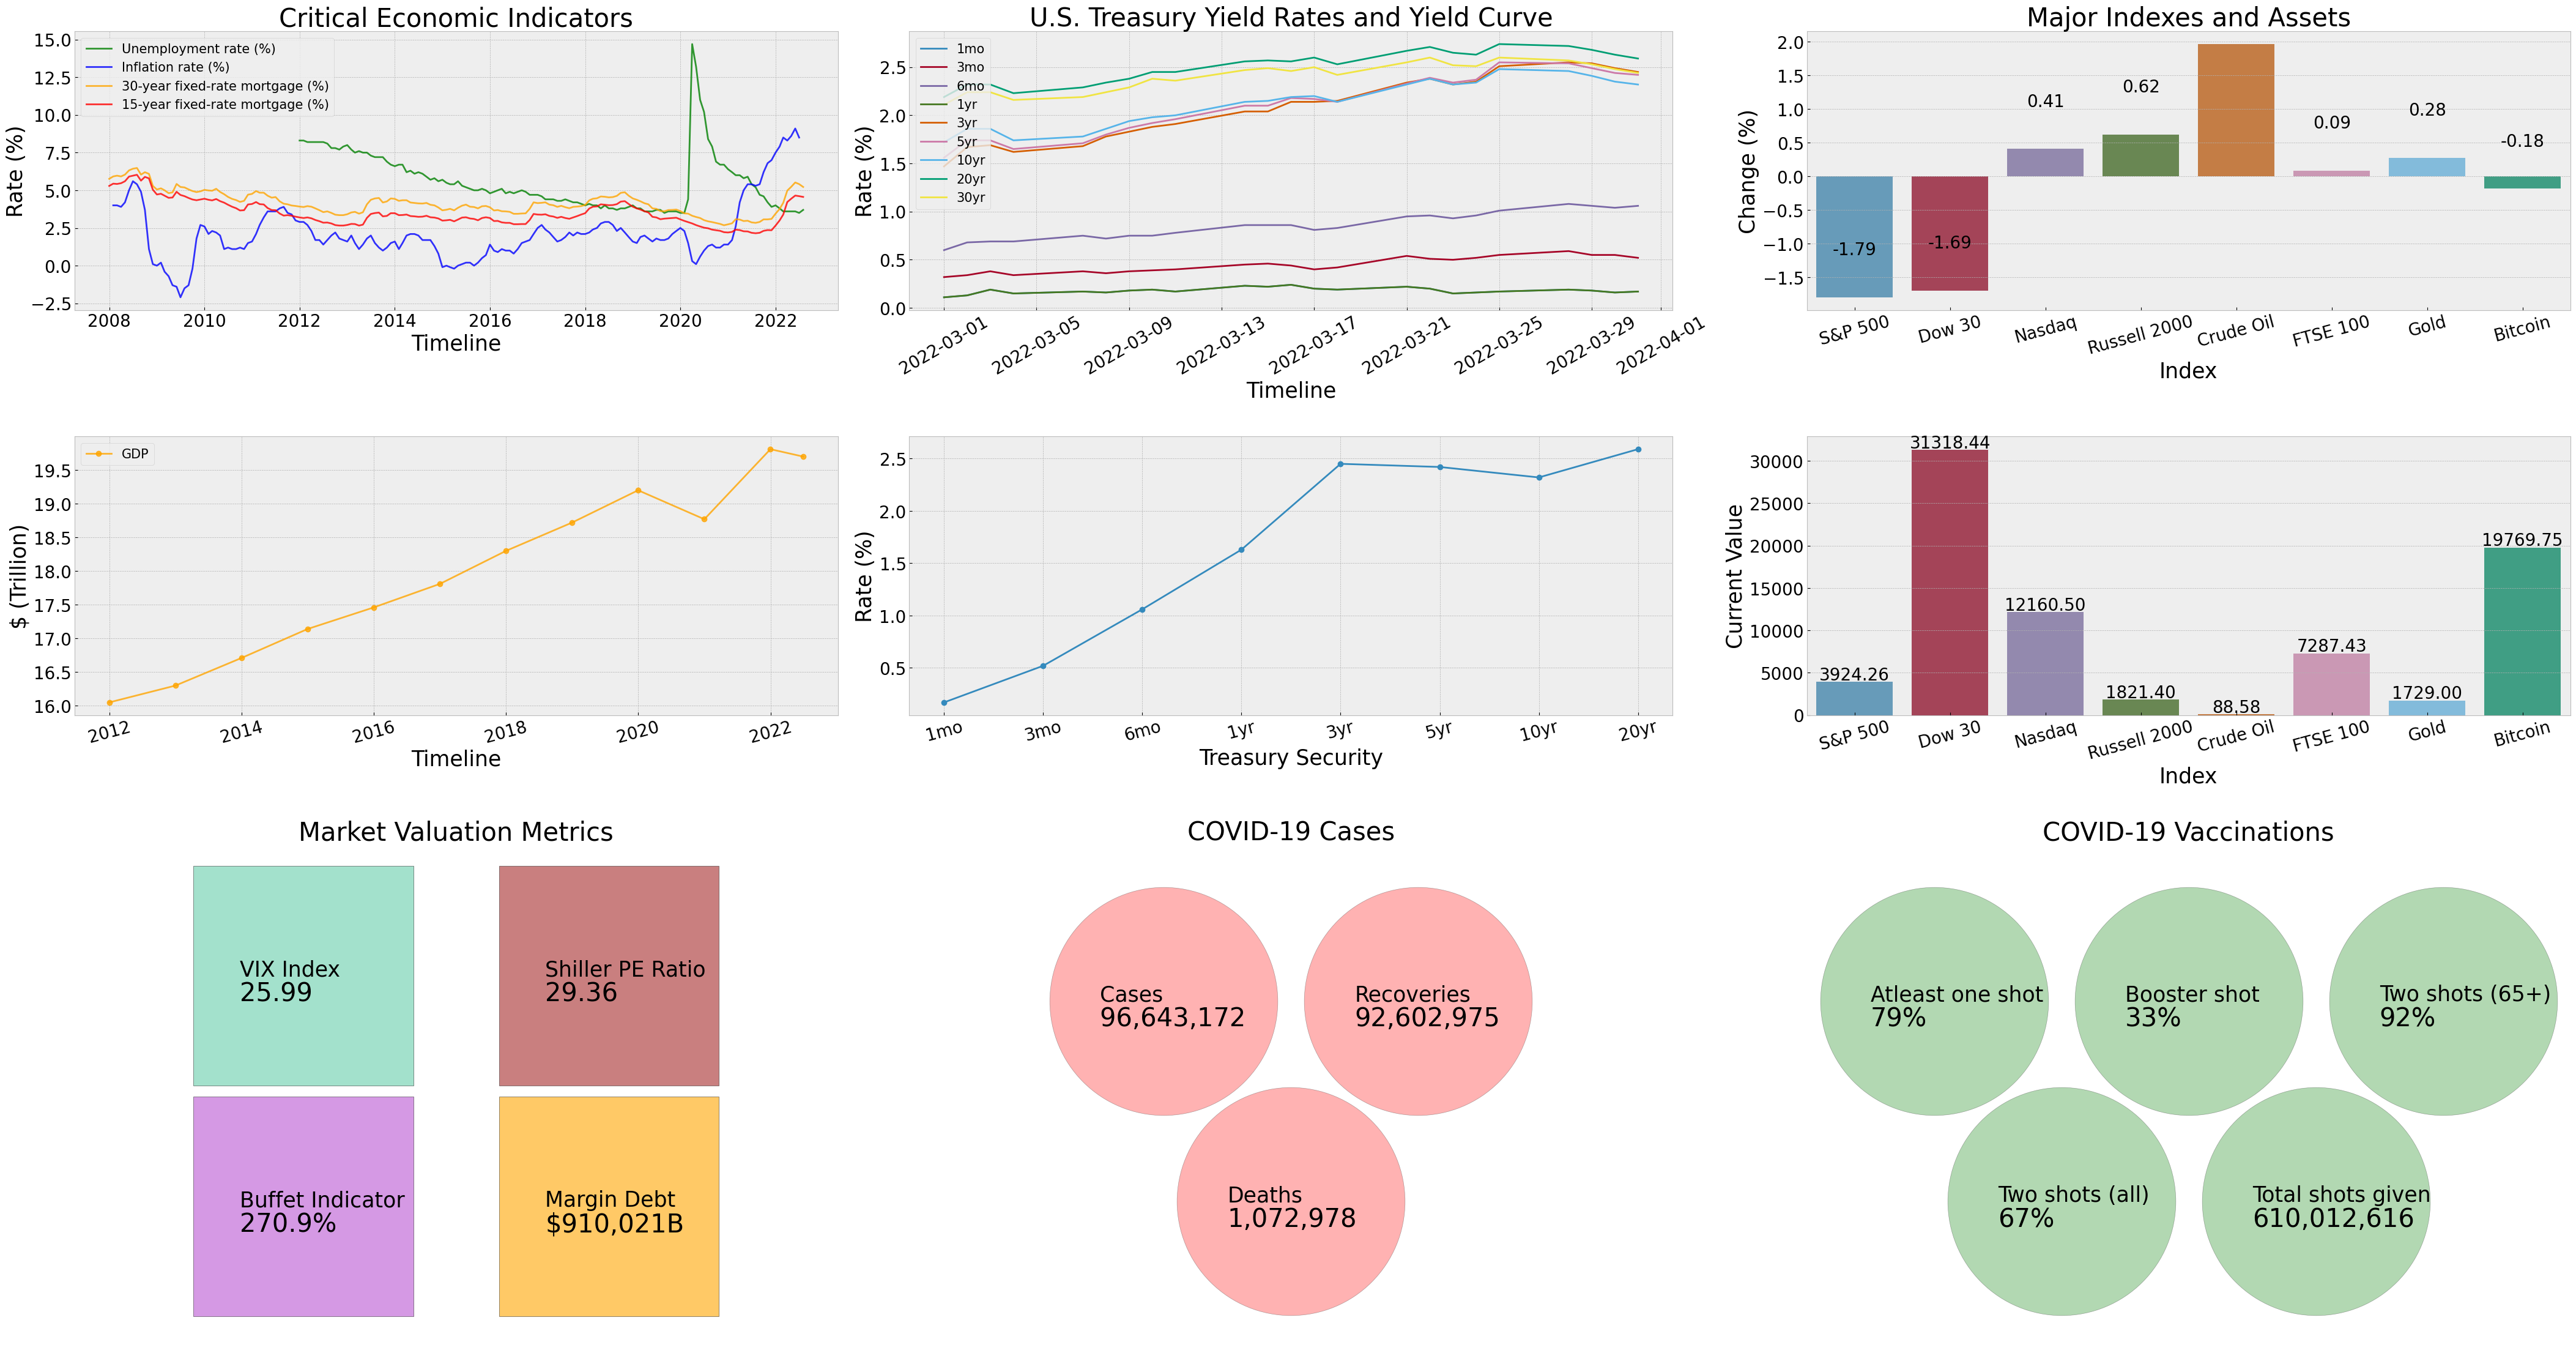

In [16]:
hp.dash_create(df_unemp_rate,df_gdp,df_inflation,df_rates,yield_curve,vix,df_index,cases,vac_values,vac_labels,buffet_ind,
              shiller_pe,df_debt,latest_data,df_mortgage_15yr,df_mortgage_30yr)